## **Shielf Insurance Premium Predictor**

**Import Required Libraries**

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor


#### **Data Cleaning & EDA - Part 1**

**Explore Dataset**

In [7]:
df = pd.read_excel("premiums_rest.xlsx")
print(df.shape)
df.head(4)

(29904, 13)


,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303


In [8]:
df['Genetical_Risk']=0

In [9]:
df['Age'].dtypes

dtype('int64')

In [10]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount', 'Genetical_Risk'],
      dtype='object')

**Normalize Column Titles**

In [11]:
df.columns.str.replace(' ','_')

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number_Of_Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical_History', 'Insurance_Plan',
       'Annual_Premium_Amount', 'Genetical_Risk'],
      dtype='object')

In [12]:
df.columns = df.columns.str.replace(' ','_').str.lower()

In [13]:
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount', 'genetical_risk'],
      dtype='object')

### **Handle NAN Values**

In [14]:
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [15]:
# Since null values are very few compared to dataset, we can just drop them
df.dropna(inplace=True)
df.isnull().sum()
df.shape

(29886, 14)

**Check & Handle Duplicates**

In [16]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [17]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29886.000000,29886.000000,29886.000000,29886.000000,29886.0
mean,43.396105,2.379910,23.364184,20892.303821,0.0
std,13.412657,1.431201,24.740339,6936.813440,0.0
min,26.000000,-3.000000,1.000000,3625.000000,0.0
25%,34.000000,1.000000,7.000000,15697.250000,0.0
50%,42.000000,3.000000,17.000000,20489.000000,0.0
75%,52.000000,3.000000,32.000000,26360.000000,0.0
max,356.000000,5.000000,930.000000,43471.000000,0.0


**Let's Treat Negative Values in Number of Dependants**

In [18]:
df[df['number_of_dependants']<0].shape

(50, 14)

In [19]:
df[df['number_of_dependants']<0].number_of_dependants.unique()

# It seems the negative values might have been due to typo, so we can apply absolute function

array([-1, -3], dtype=int64)

In [20]:
df['number_of_dependants'] = abs(df['number_of_dependants'])

In [21]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29886.000000,29886.000000,29886.000000,29886.000000,29886.0
mean,43.396105,2.385933,23.364184,20892.303821,0.0
std,13.412657,1.421137,24.740339,6936.813440,0.0
min,26.000000,0.000000,1.000000,3625.000000,0.0
25%,34.000000,1.000000,7.000000,15697.250000,0.0
50%,42.000000,3.000000,17.000000,20489.000000,0.0
75%,52.000000,3.000000,32.000000,26360.000000,0.0
max,356.000000,5.000000,930.000000,43471.000000,0.0


**Check Distribution of Numerical Features**

In [22]:
# This is how to fetch all numeric columns in your dataset

df.select_dtypes(['float64', 'int64'])

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
0,26,0,6,9053,0
1,29,2,6,16339,0
2,49,2,20,18164,0
3,30,3,77,20303,0
4,56,3,14,15610,0
...,...,...,...,...,...
29899,60,3,26,26370,0
29900,40,0,16,29496,0
29901,37,0,4,10957,0
29902,47,2,82,27076,0


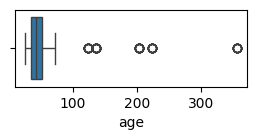

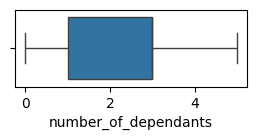

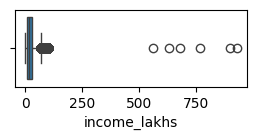

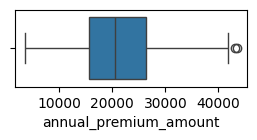

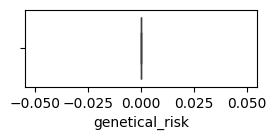

In [23]:
numerical_features = df.select_dtypes(['float64', 'int64']).columns

for feature in numerical_features:
    plt.figure(figsize=(3,1))
    sns.boxplot(x = df[feature])
    

**Treat Outliers in Age Using Threshold (max_Age=100)**

In [24]:
df[df.age>100].age.unique()

array([224, 124, 136, 203, 356], dtype=int64)

In [25]:
df1 = df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29828.000000,29828.000000,29828.000000,29828.000000,29828.0
mean,43.095380,2.387790,23.371530,20901.900563,0.0
std,11.041991,1.420641,24.751262,6928.457636,0.0
min,26.000000,0.000000,1.000000,6538.000000,0.0
25%,34.000000,1.000000,7.000000,15706.000000,0.0
50%,42.000000,3.000000,17.000000,20496.000000,0.0
75%,52.000000,3.000000,32.000000,26361.000000,0.0
max,72.000000,5.000000,930.000000,43471.000000,0.0


**Treat Outliers in Income Using IQR**

<Axes: >

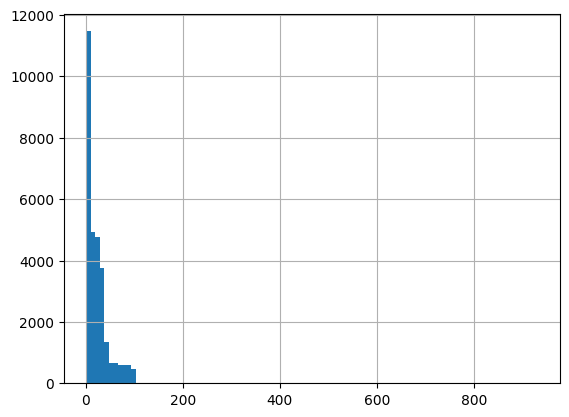

In [26]:
df1['income_lakhs'].hist(bins=100)

In [27]:
df1['income_lakhs'].quantile([0.25,0.75])


0.25     7.0
0.75    32.0
Name: income_lakhs, dtype: float64

In [28]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25,0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    return lower_bound, upper_bound

In [29]:
get_iqr_bounds(df1.income_lakhs)

# we won't worry on the lower_bound rather on the upper bound, 67, which is not that extreme

(-30.5, 69.5)

In [30]:
# Rather we can choose to set a threshold

quantile_threshold = df1['income_lakhs'].quantile(0.999)
quantile_threshold

100.0

In [31]:
df1[df1['income_lakhs']>quantile_threshold]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
1598,51,Male,Northwest,Married,4,Obesity,No Smoking,Self-Employed,> 40L,560,High blood pressure,Gold,30692,0
4657,35,Female,Northeast,Unmarried,0,Overweight,No Smoking,Salaried,> 40L,630,Diabetes,Gold,24010,0
5399,43,Male,Southeast,Married,3,Obesity,Regular,Salaried,> 40L,900,Diabetes & Thyroid,Gold,30848,0
6149,37,Female,Southeast,Married,3,Normal,No Smoking,Freelancer,> 40L,930,Diabetes,Silver,15945,0
21176,59,Male,Northwest,Married,2,Obesity,Occasional,Self-Employed,> 40L,770,Thyroid,Gold,31115,0
24489,48,Male,Northeast,Married,4,Obesity,No Smoking,Salaried,> 40L,680,No Disease,Gold,28926,0


In [32]:
# Since just a total of 10 people has income above the set threshold, we can then decide to drop them

df2 = df1[df1['income_lakhs']<=quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.0
mean,43.094896,2.387734,23.226343,20900.689223,0.0
std,11.042430,1.420644,22.455408,6928.192115,0.0
min,26.000000,0.000000,1.000000,6538.000000,0.0
25%,34.000000,1.000000,7.000000,15705.250000,0.0
50%,42.000000,3.000000,17.000000,20495.500000,0.0
75%,52.000000,3.000000,32.000000,26360.000000,0.0
max,72.000000,5.000000,100.000000,43471.000000,0.0


#### **Data Cleaning & EDA - Part 2**

**View Numerical Data on Histogram: Univariate Analysis**

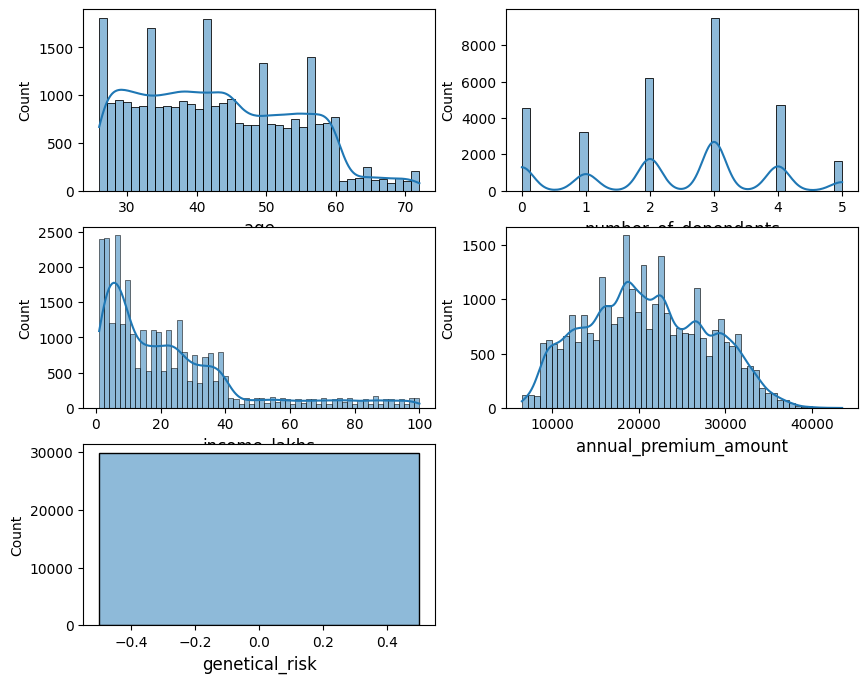

In [36]:
import math
numerical_features = df2.select_dtypes(['float64', 'int64']).columns

n = len(numerical_features)

fig, axes = plt.subplots(math.ceil(n/2),2,figsize=(10,8))
axes = axes.flatten()

for i,feature in enumerate(numerical_features):
    sns.histplot(data = df2, x = feature, kde=True, ax=axes[i])
    axes[i].set_xlabel(feature, fontsize=12)

for j in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[j])
    
plt.show()

**Bivariate Analysis of Numerical Features w.r.t annual_premium_income**

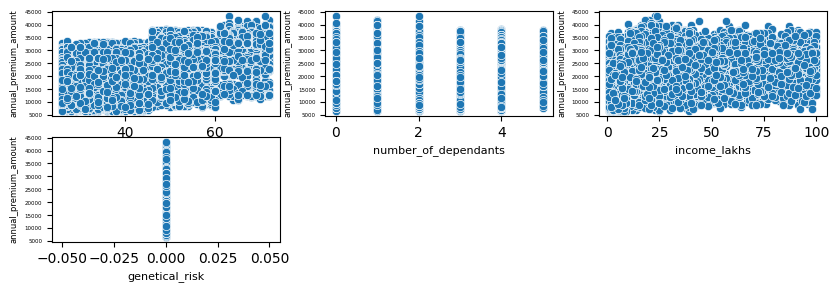

In [38]:
numerical_features = df2.select_dtypes(['float64', 'int64']).columns
bivariate_features = numerical_features.drop('annual_premium_amount')

n = len(numerical_features)

fig, axes = plt.subplots(math.ceil(n/3),3,figsize=(10,3))
axes = axes.flatten()

for i,feature in enumerate(bivariate_features):
    sns.scatterplot(data = df2, x=feature, y='annual_premium_amount', ax=axes[i])
    axes[i].set_xlabel(feature, fontsize=8)
    axes[i].set_ylabel('annual_premium_amount', fontsize=6)
    axes[i].tick_params(axis='y', labelsize=4)
for j in range(len(bivariate_features), len(axes)):
    fig.delaxes(axes[j])

plt.show()


**Categorical Columns EDA**

In [39]:
categorical_features = df2.select_dtypes(['object']).columns
categorical_features
for col in categorical_features:
    print(col, ':', df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [40]:
df2['smoking_status'].replace({
    'Smoking=0': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Not Smoking': 'No Smoking'
}, inplace=True)
df2['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [41]:
get_count = df2.gender.value_counts(normalize=True)*100
get_count

gender
Male      54.912481
Female    45.087519
Name: proportion, dtype: float64

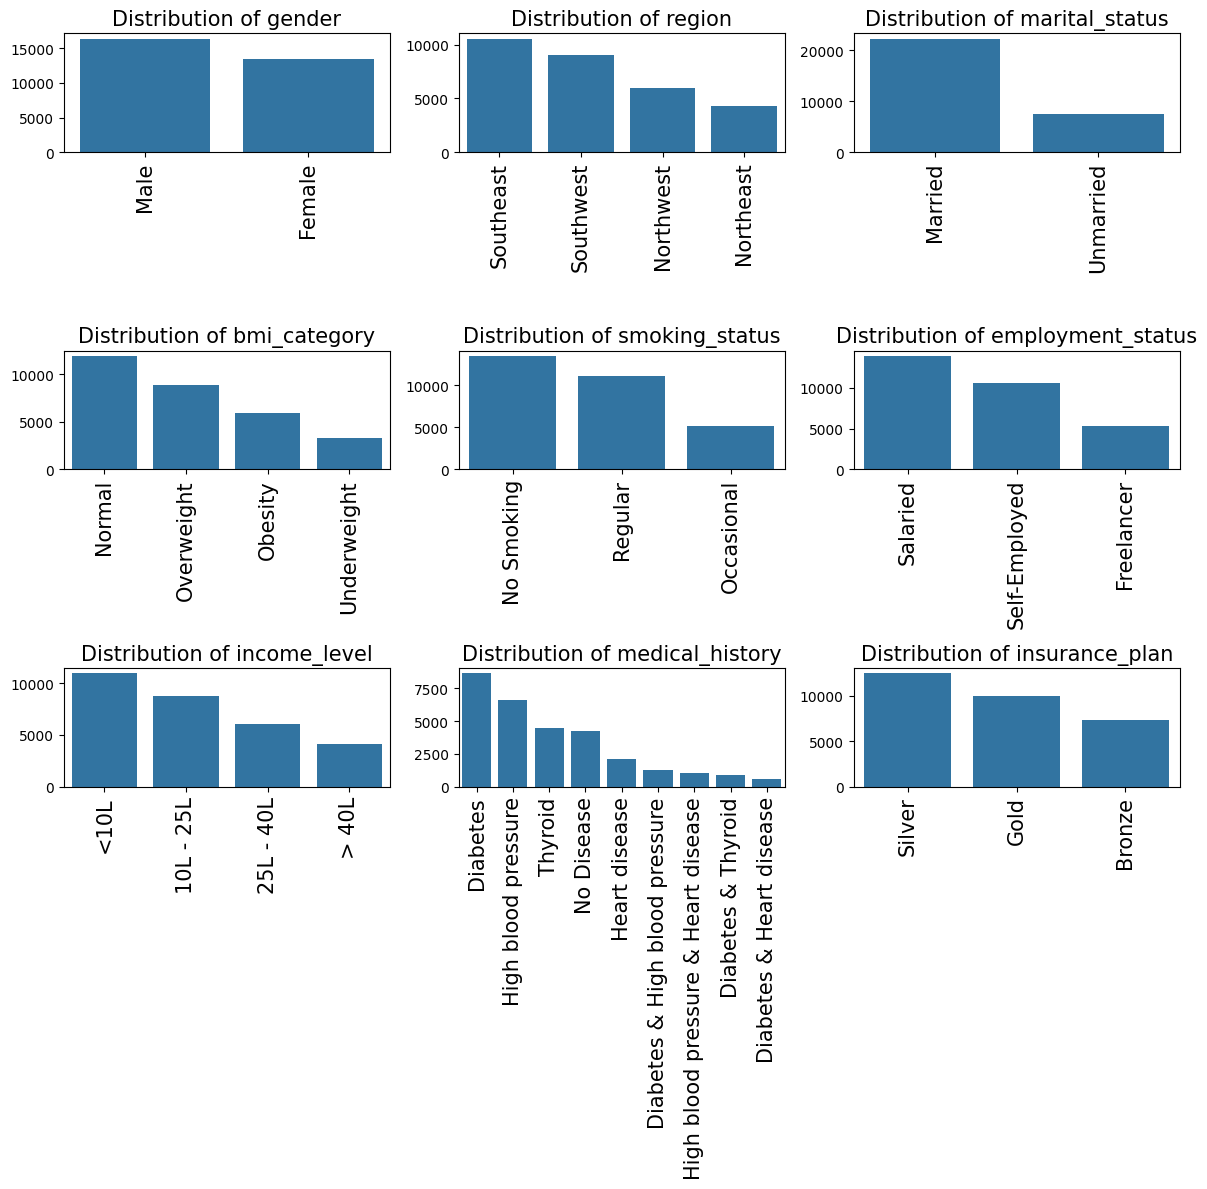

In [42]:
import math
categorical_features = df2.select_dtypes(['object']).columns
n = len(categorical_features)
rows = math.ceil(n / 3)

fig, axes = plt.subplots(rows, 3, figsize=(12,12))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    get_count = df2[col].value_counts()
    sns.barplot(x=get_count.index, y=get_count.values, ax = axes[i])
    axes[i].set_title(f'Distribution of {col}', fontsize=15)
    axes[i].tick_params(axis='x', rotation=90, labelsize=15)
    axes[i].tick_params(axis='y', labelsize=10)
    axes[i].set_xlabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



**Crosstab ::: Cross Tabulation**

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L          799  3554    4354
25L - 40L          301  2631    3142
<10L              6054   527    4341
> 40L              214  3287     618


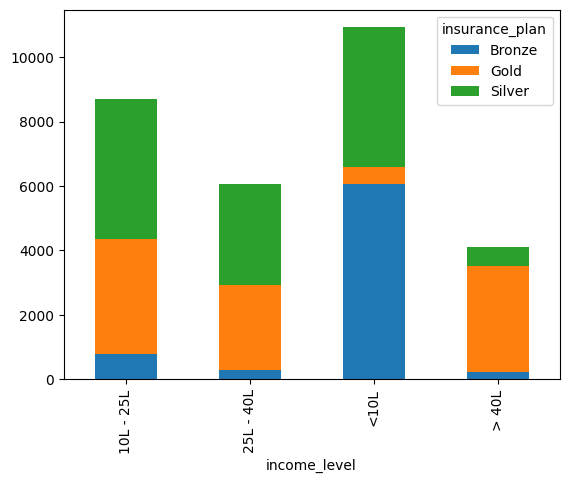

In [44]:
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(crosstab)

crosstab.plot(kind='bar', stacked=True)
plt.show()

<Axes: xlabel='insurance_plan', ylabel='income_level'>

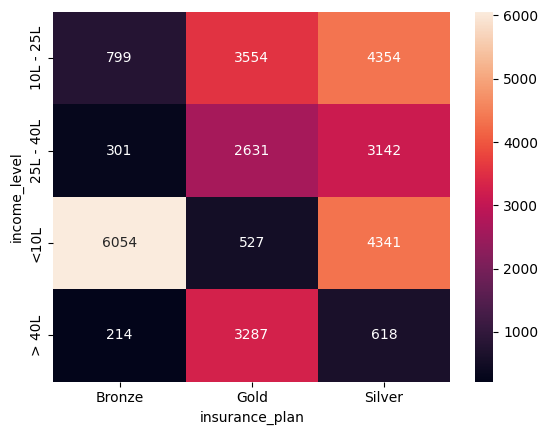

In [45]:
sns.heatmap(crosstab,fmt='d', annot=True)

#### **Feature Engineering: Converting Text to Numbers**

In [46]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0


In [47]:
df2.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

**Normalizing medical_history column**

In [48]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [49]:
risk_scores = {
    'diabetes': 6,
    'heart disease': 8,
    'high blood pressure': 6,
    'thyroid': 5,
    'no disease': 0,
    'none': 0
}

df2[['disease1', 'disease2']] = df2['medical_history'].str.split('&', expand=True).apply(lambda x: x.str.strip().str.lower())
df2.head(4)




,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0,high blood pressure,None
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0,no disease,None


In [50]:
df2.isnull().sum()

age                          0
gender                       0
region                       0
marital_status               0
number_of_dependants         0
bmi_category                 0
smoking_status               0
employment_status            0
income_level                 0
income_lakhs                 0
medical_history              0
insurance_plan               0
annual_premium_amount        0
genetical_risk               0
disease1                     0
disease2                 26058
dtype: int64

In [51]:
df2[df2['disease2'].isnull()].shape

(26058, 16)

In [52]:
df2['disease1'].fillna('none',inplace=True)
df2['disease2'].fillna('none',inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)



In [53]:
df2.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
disease1                 0
disease2                 0
total_risk_score         0
dtype: int64

**Scale Total Risk Score with MinMaxScaler Approach**

In [54]:
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score)/(max_score - min_score)
df2.head(4)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0,no disease,none,0,0.000000


**Normalizing insurance_plan column**

In [55]:
df2.insurance_plan.unique()

# # It's more like an ordinal categorical variable

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [56]:
df2['insurance_plan'] = df2.insurance_plan.map({'Bronze':1, 'Silver':2, 'Gold':3})
df2.head(4)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,1,9053,0,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,1,16339,0,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,2,18164,0,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,3,20303,0,no disease,none,0,0.000000


In [ ]:
# df2[df2['normalized_risk_score'].isnull()]

**Normalizing income_level column**

In [57]:
df2.income_level.unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [58]:
df2['income_level'] = df2.income_level.map({'<10L':1, '10L - 25L':2, '25L - 40L':3, '> 40L':4})

In [59]:
df2.head(4)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,0,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,0,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,0,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,4,77,No Disease,3,20303,0,no disease,none,0,0.000000


**Normalizing Nominal columns: One Hot Encoding**

In [60]:
nominal_cols = ['gender',	'region',	'marital_status','bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns = nominal_cols, drop_first = True, dtype=int)
df3.head(4)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,0,diabetes,none,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,0,diabetes,none,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,0,high blood pressure,none,...,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,0,no disease,none,...,1,0,0,0,0,0,0,0,1,0


In [61]:
df4 = df3.drop(['medical_history', 'disease1', 'disease2', 'total_risk_score'], axis=1)

In [62]:
df4.isnull().sum()

age                                0
number_of_dependants               0
income_level                       0
income_lakhs                       0
insurance_plan                     0
annual_premium_amount              0
genetical_risk                     0
normalized_risk_score              0
gender_Male                        0
region_Northwest                   0
region_Southeast                   0
region_Southwest                   0
marital_status_Unmarried           0
bmi_category_Obesity               0
bmi_category_Overweight            0
bmi_category_Underweight           0
smoking_status_Occasional          0
smoking_status_Regular             0
employment_status_Salaried         0
employment_status_Self-Employed    0
dtype: int64

**Feature Selection: Correlation and VIF**

**Correlation**

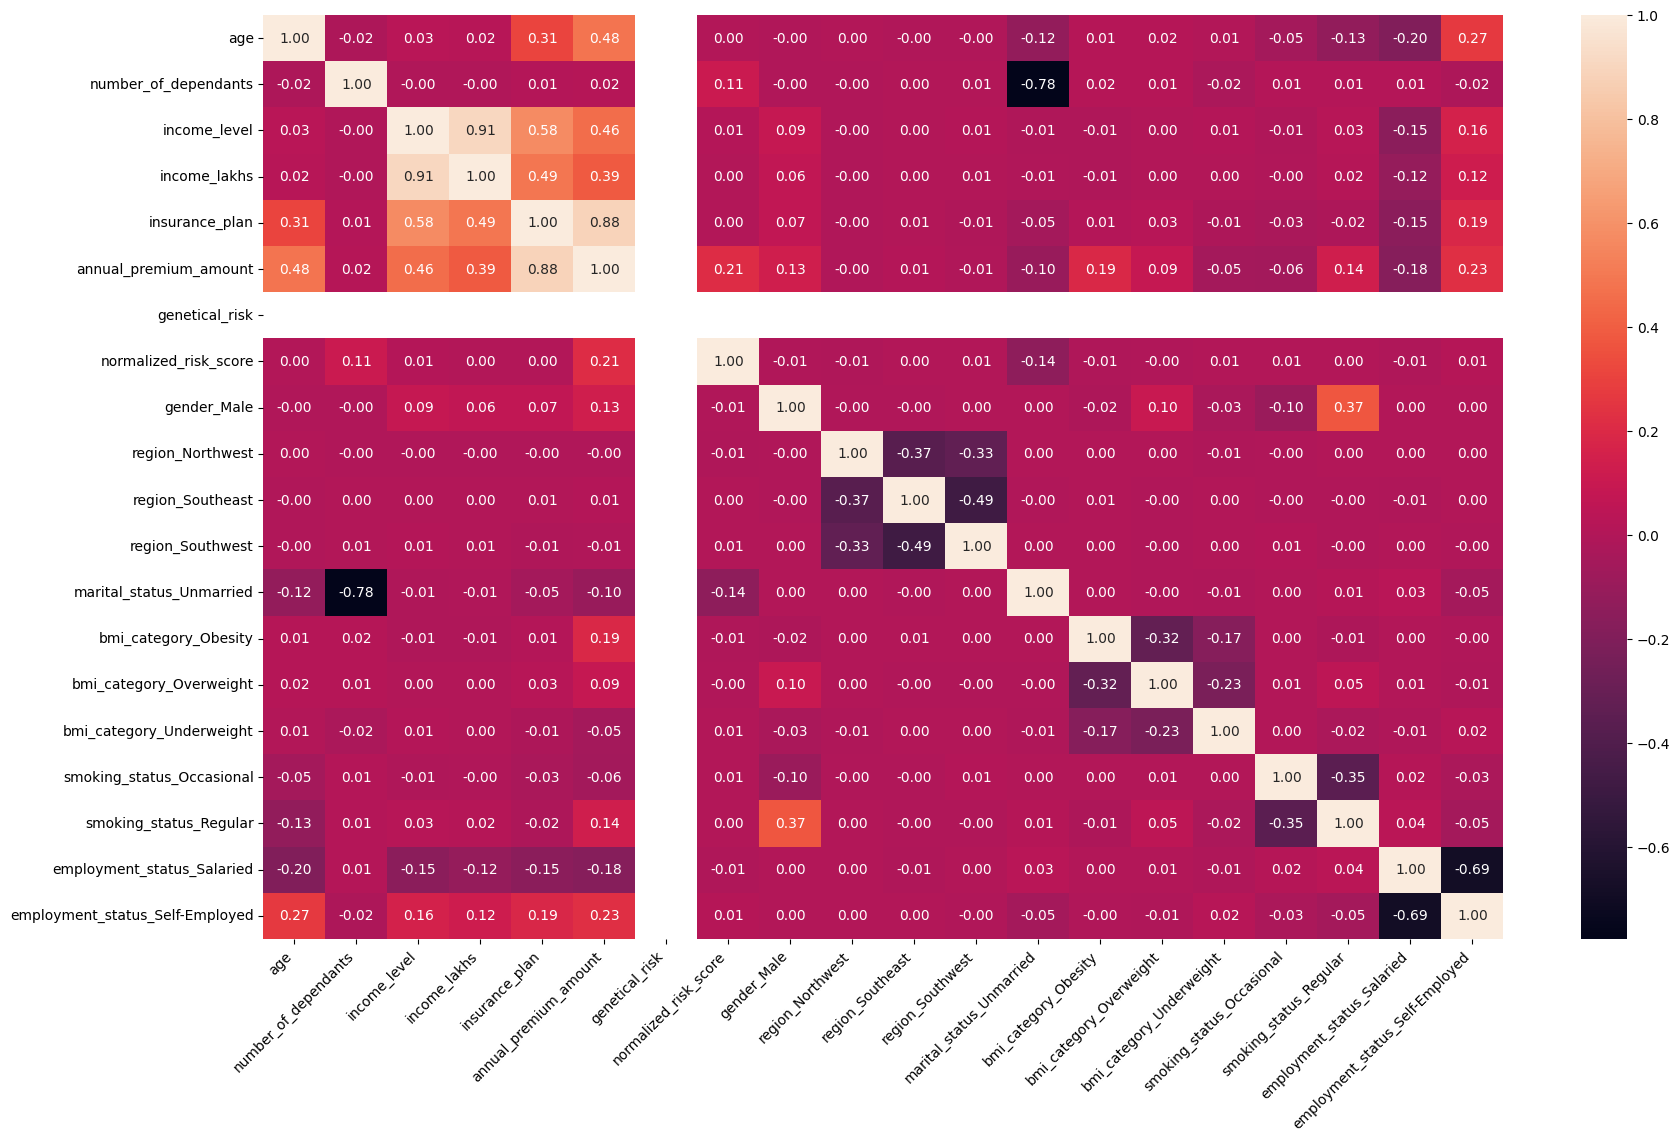

In [63]:
cm = df4.corr()
plt.figure(figsize=(20,12))
sns.heatmap(cm, fmt='.2f', annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

**VIF - Process**

In [64]:
df4.head(4)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,20303,0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0


In [70]:
X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler
cols_to_scale = ['age','income_lakhs', 'number_of_dependants' ,'income_level', 'insurance_plan', 'genetical_risk']
scaler = MinMaxScaler()
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.head(4)
X.isnull().sum()

age                                0
number_of_dependants               0
income_level                       0
income_lakhs                       0
insurance_plan                     0
genetical_risk                     0
normalized_risk_score              0
gender_Male                        0
region_Northwest                   0
region_Southeast                   0
region_Southwest                   0
marital_status_Unmarried           0
bmi_category_Obesity               0
bmi_category_Overweight            0
bmi_category_Underweight           0
smoking_status_Occasional          0
smoking_status_Regular             0
employment_status_Salaried         0
employment_status_Self-Employed    0
dtype: int64

In [66]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df

In [67]:
calculate_vif(X)

C:\Users\sidowu\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,Column,VIF
0,age,3.921783
1,number_of_dependants,6.278938
2,income_level,13.890522
3,income_lakhs,11.185596
4,insurance_plan,5.271297
5,genetical_risk,NaN
6,normalized_risk_score,3.810619
7,gender_Male,2.599098
8,region_Northwest,2.123965
9,region_Southeast,2.980842


In [72]:
# Due to high Correlation between income_level & income_lakhs, 
# We drop the feature with the highest value; income_level

calculate_vif(X.drop('income_level', axis='columns'))

C:\Users\sidowu\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,Column,VIF
0,age,3.863055
1,number_of_dependants,6.278147
2,income_lakhs,2.678102
3,insurance_plan,4.574625
4,genetical_risk,NaN
5,normalized_risk_score,3.808345
6,gender_Male,2.591439
7,region_Northwest,2.123277
8,region_Southeast,2.979899
9,region_Southwest,2.708641


In [73]:
X_reduced = X.drop('income_level', axis='columns')
X_reduced.head(4)

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.050505,0.0,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.050505,0.0,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.191919,0.5,0.0,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,0.767677,1.0,0.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0


### **Model Training**

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=10)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (20875, 18)
X_test:  (8947, 18)
y_train:  (20875,)
y_test:  (8947,)


**Train Linear Regression**

In [75]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score, test_score

# Doing a train_score is to check the performance of both train and test dataset.
# When tran_set is overfitting, the score will be higher than test_set.
# There's no overfitting.

(0.9534163989489616, 0.9538448451629948)

In [76]:
X_test.head(1)

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
19713,0.652174,0.0,0.262626,1.0,0.0,0.428571,0,0,0,1,1,0,0,0,0,0,0,1


In [77]:
model_lr.intercept_

5935.981289344458

In [78]:
 model_lr.coef_

array([ 7.01623933e+03, -1.31176470e+03, -7.08193369e+02,  1.48359882e+04,
       -2.27373675e-12,  6.05362412e+03,  3.75582688e+01, -5.52508721e+01,
       -1.96225429e+01, -2.22896756e+01, -7.00320200e+02,  3.92681271e+03,
        1.97945605e+03,  6.12866236e+02,  8.37395101e+02,  2.80066184e+03,
       -4.54913671e+01,  2.43078421e+02])

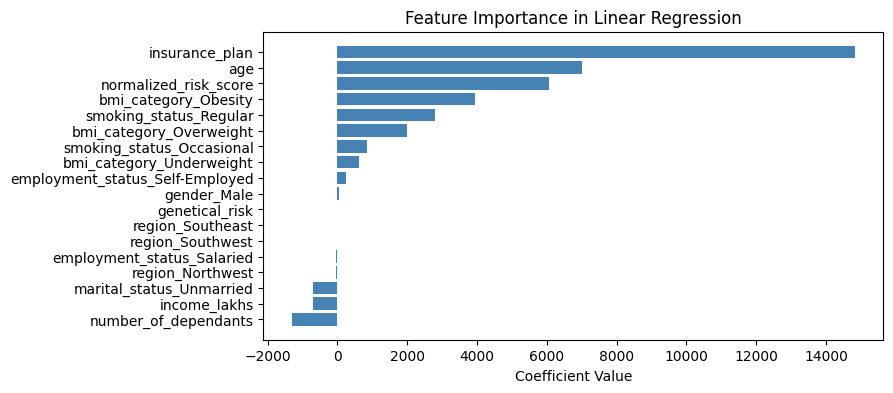

In [79]:
feature_importances = model_lr.coef_

coef_df = pd.DataFrame(feature_importances, index=X_test.columns, columns=['Coefficients'])
coef_df_sorted = coef_df.sort_values(by='Coefficients',ascending=True)
coef_df_sorted

plt.figure(figsize=(8,4))
plt.barh(coef_df_sorted.index, coef_df_sorted['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

**Train Ridge Regression**

In [80]:
model_rg = Ridge()
model_rg.fit(X_train, y_train)
train_score = model_rg.score(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score, test_score

(0.9534162332209687, 0.9538456995663842)

**Train XGBoost Regressor**

In [81]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)
train_score, test_score

(0.9986370761718086, 0.9979538491004899)

**Applying RandomSearchCV for Best Hyperparameter to Fine Tune Model: XGBoost**

In [83]:
model_xgb = XGBRegressor()
params_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3,4,5]
}

random_search = RandomizedSearchCV(model_xgb, params_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
print(random_search.best_params_)
random_search.best_score_


{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}


0.9970577807993951

In [85]:
best_model = random_search.best_estimator_

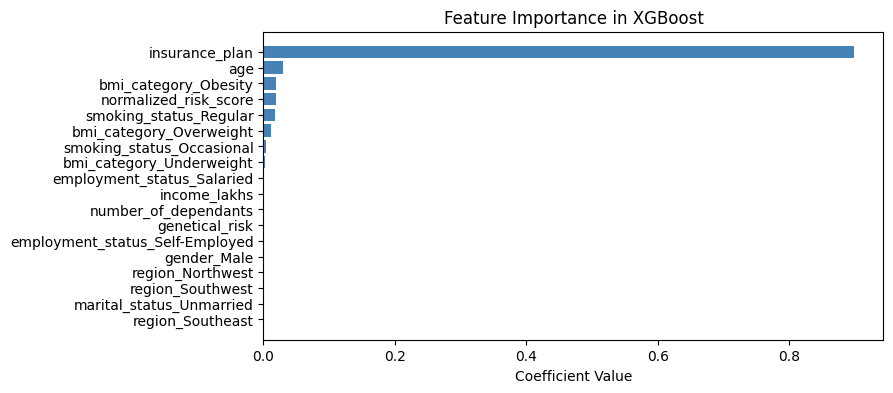

In [86]:
feature_importances = best_model.feature_importances_

coef_df = pd.DataFrame(feature_importances, index=X_test.columns, columns=['Coefficients'])
coef_df_sorted = coef_df.sort_values(by='Coefficients',ascending=True)
coef_df_sorted

plt.figure(figsize=(8,4))
plt.barh(coef_df_sorted.index, coef_df_sorted['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

### **Error Analysis**

In [87]:
# Let's check the level of error margin between the y_test and y_pred
y_pred = best_model.predict(X_test)

residuals = y_pred-y_test
residuals_pct = residuals*100/y_test

results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'diff': residuals,
    'diff_pct': residuals_pct
})
results_df.head(4)

,actual,predicted,diff,diff_pct
19713,26895,26691.470703,-203.529297,-0.756755
14750,22734,22650.751953,-83.248047,-0.366183
19932,21198,21581.894531,383.894531,1.810994
29643,9100,9425.934570,325.934570,3.581699


<Axes: xlabel='diff_pct', ylabel='Count'>

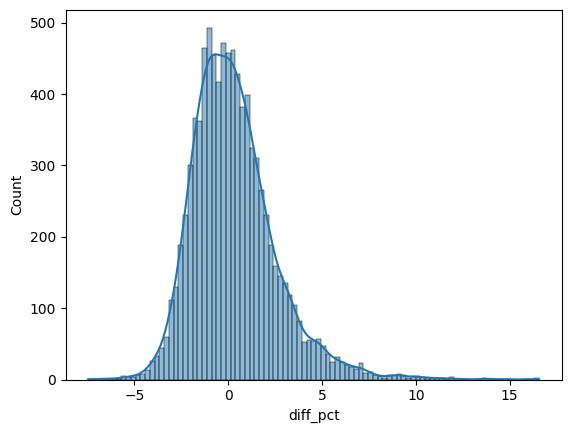

In [88]:
# It will be useful to see the distribution of the margin
sns.histplot(results_df['diff_pct'], kde=True)

In [89]:
# Having an error margin as high as 80% is not a good one

extreme_error_threshold = 10
extreme_results_df = results_df[np.abs(results_df.diff_pct)>extreme_error_threshold]
print(extreme_results_df.shape)
extreme_results_df

(29, 4)


,actual,predicted,diff,diff_pct
14286,6845,7621.263672,776.263672,11.340594
27518,8502,9425.934570,923.934570,10.867261
9285,6872,7621.263672,749.263672,10.903138
7547,6538,7621.263672,1083.263672,16.568732
21910,6651,7621.263672,970.263672,14.588237
12189,6571,7621.263672,1050.263672,15.983316
21141,10722,11841.492188,1119.492188,10.441076
16263,8206,9063.517578,857.517578,10.449885
8216,6635,7621.263672,986.263672,14.864562
13973,10583,11841.492188,1258.492188,11.891639


In [90]:
# Percentage of predictions with %_error above 10%
extreme_error_pct = extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_error_pct

0.32413099362914943

We have very few extreme errors (only 0.3%) which means this model looks good and no further investigation is required

### **Model Export**

In [97]:
cols_to_scale

['age',
 'income_lakhs',
 'number_of_dependants',
 'income_level',
 'insurance_plan',
 'genetical_risk']

In [98]:
from joblib import dump

dump(best_model, "artifacts_/model_rest.joblib")
scaler_with_cols = {
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}
dump(scaler_with_cols, "artifacts_/scaler_rest.joblib")

['artifacts_/scaler_rest.joblib']